In [90]:
import torch 
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dataset
import matplotlib.pylab as plt
import numpy as np

## Chuẩn bị Dataset
+ Tập Training
+ Tập Testing   

Chuyển ảnh thành Tensor thì Tensor sẽ là 1 Tensor 3D. Ở bài toán này sử Tensor có size: (1, 28, 28). Trong đó 1 ở đây là số màu. Nếu là ảnh màu sẽ lả (3, 28, 28)

In [91]:
train_dataset = dataset.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
valid_dataset = dataset.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [92]:
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [93]:
# Kiểm tra kích thước Tensor
print(train_dataset[1][0].size())

torch.Size([1, 28, 28])


In [94]:
# Kiểm tra nhãn 
print(train_dataset[5][1])

2


## Tạo Class Module

In [95]:
class Softmax_Regression(nn.Module):
    def __init__(self, input_size, output_size):
        super(Softmax_Regression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

criterion = nn.CrossEntropyLoss()

## Tạo Module, DataLoader, Optimazer

In [96]:
input_size = 28 * 28
output_size = 10
model = Softmax_Regression(input_size, output_size)
trainloader = DataLoader(dataset=train_dataset, batch_size=1000)
validloader = DataLoader(dataset=valid_dataset, batch_size=5000)
optimazer = optim.SGD(model.parameters(), lr=0.01)

## Khởi tạo bộ trọng số w, bias

In [97]:
w_start = torch.ones(10, 784)
b_start = torch.ones(10)
model.state_dict()['linear.weight'][:] = w_start
model.state_dict()['linear.bias'][:] = b_start

## Training
+ Khi Validate, t sẽ kí hiệu z thay vì yhat là vì z kết quả của model(x) trả về là xác suất của x khi rơi và các nhãn. z ở đây có 10 giá trị tương trưng cho 10 xs của 10 nhãn. các giá trị của z chính là mũ của tử số của công thức  
$$Activation Function: P_k(X_i) = \frac{e^{X_i W_k + W_{0,k}}}{\sum_{l=0}^{K-1}(e^{X_i W_l + W_{0,l}})}$$
+ yhat sẽ được tính sau trong hàm CrossEntropyLoss() 
+ <u>*Ko cần cho z qua hàm Softmax*</u> là vì ta chỉ cần so sánh phần tử số xem cái nào lớn nhất thì là nhãn đó  
**Chú ý:** Hàm transform.toTensor() chỉ chuyển ảnh thành Tensor 2D.Muốn sử dụng Tensor này trong mô hình thì phải chuyển nó về dạng Tensor 1D. vì hàm Linear sử dụng trong class Module chỉ có coi môi dòng (Tensor 1D) như là 1 Sample, điều này giúp nó thực hiện các phép toán trên ma trận 1 cách song song trên GPU     
<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter3/3.32_image_values.png" width="550" alt="MNIST elements">  


In [102]:
accurancy = []
COST = []
N = len(valid_dataset)   # số sample trong valid_set
def training(epochs):
    for epoch in range(epochs):
        for x,y in trainloader:
            z = model(x.view(-1, 28*28))    # chuyển x thành Tensor 1D 
            loss = criterion(z, y)
            optimazer.zero_grad()
            loss.backward()
            optimazer.step()
        
        correct = 0
        for x,y in validloader:
            z = model(x.view(-1, 28*28))
            _,yhat = torch.max(z, 1)      # yhat là vị trí Tensor lớn nhất, tương ứng với giá trị nhãn; _ là giá trị Tensor lớn nhất.
            correct += (y==yhat).sum().item()
            
        accurancy.append(correct/N)    

training(10)

## Vẽ biểu đồ

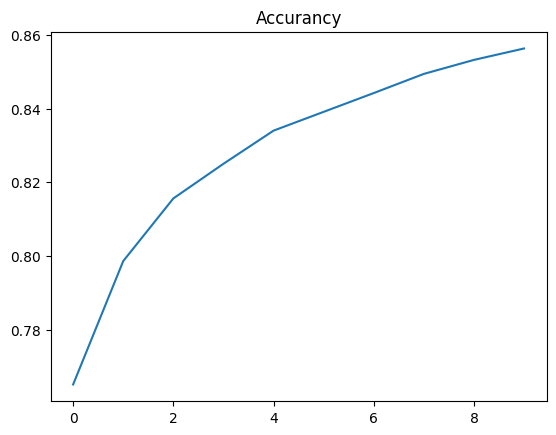

In [99]:
plt.plot(range(0, 10), accurancy)
plt.title('Accurancy')
plt.show()

## Xem kết quả 
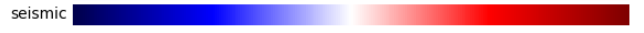  
+ Plot w, màu càng đỏ giá trị càng lớn, màu càng xanh thì càng nhỏ, màu trắng là giá trị ở giữa.  
+ sử dụng vmin, vmax để ánh xạ bảng màu này vào giá trị của w. ví dụ w=[1, 2, 3, 4] thì màu xanh đậm nhất tương ứng w=1, màu đỏ đậm nhất tương ứng w=4  
**Chú ý:** khi chia thành fig và axes, thì tất cả các hàm dùng cho plt, ví dụ <u>*plt.xlabel()*</u> thì đều gắn thêm chữ set ở tên, ví du. <u>*axes.set_xlabe()*</u>

In [100]:
# Plot w, màu càng đỏ thì càng lớn, màu càng xanh thì càng nhỏ, màu trắng là giá trị ở giữa
def PlotParameters(model): 
    w = model.state_dict()['linear.weight'][:]
    fig,axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    w_min = w.min().item()    # giá trị nhỏ nhất trong bảng màu cmap sẽ đc ánh xạ tới giá trị này
    w_max = w.max().item()    # giá trị lớn nhất trong bảng màu cmap sẽ đc ánh xạ tới giá trị này
    for i,ax in enumerate(axes.flat):
        ax.imshow(w[i].view(28, 28), vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(f'class: {i}')
    plt.show()  

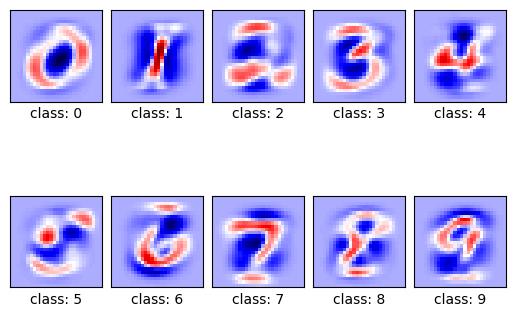

In [101]:
 PlotParameters(model)